# Introduction
***
## The Game of Life
John Conway's *Game of Life* was developed in 1970 as a sort of cellular automaton. This so-called-game is a grid of cells that rely on two states, alive or dead, and the following set of rules:

1. Each living cell with one or no neighbors dies
2. Each living cell with four or more neighbors dies
3. Each living cell with two or three neighbors lives
4. Each dead cell with three living neighbors is brought back to life

But what do we mean by "neighbors"? For any given cell *A*, the neighbors of *A* include the 8 cells touching *A* (meaning the cells diagonal from *A* are neighbors of *A*). We can code Conway's *Game of Life* by first importing some vital functionality such as `matplotlib`.

In [3]:
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
%matplotlib notebook

We will take a quick look at the following code for Conway's *Game of Life*, but we will explore with more depth when we begin to build our end goal, a variable epidemic simulator.

First, we set the grid size manually, but this can be turned into an input later on. The function `update(grid)` takes a tuple representing the side lengths of the game's grid. We make a copy of the grid and apply the rules of Conway's *Game of Life* to each cell, one at a time, using a nested `for` loop. We then return the copy after apply the rules as if one day or one iteration has passed for the cells in the grid.

In [4]:
# Set up the size of the grid
grid_size = (50, 50)

# Function to update the state of the grid for each iteration
def update(grid):
    # 0 = dead, 1 = alive
    new_grid = np.zeros(grid_size)
    
    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            # Count the number of live neighbors (since dead = 0, the sum = the # of neighbors)
            neighbors_sum = np.sum(grid[max(0, i-1):min(i+2, grid_size[0]), max(0, j-1):min(j+2, grid_size[1])]) - grid[i, j]
            # grid[i, j] is the center, so subtracting it's value gives the true number of neighbors
            
            if grid[i, j] == 1:
                # Cell is alive
                if neighbors_sum < 2 or neighbors_sum > 3:
                    new_grid[i, j] = 0  # Rule 1 and Rule 2
                else:
                    new_grid[i, j] = 1  # Rule 3
            else:
                # Cell is dead
                if neighbors_sum == 3:
                    new_grid[i, j] = 1  # Rule 4
    
    return new_grid

<IPython.core.display.Javascript object>


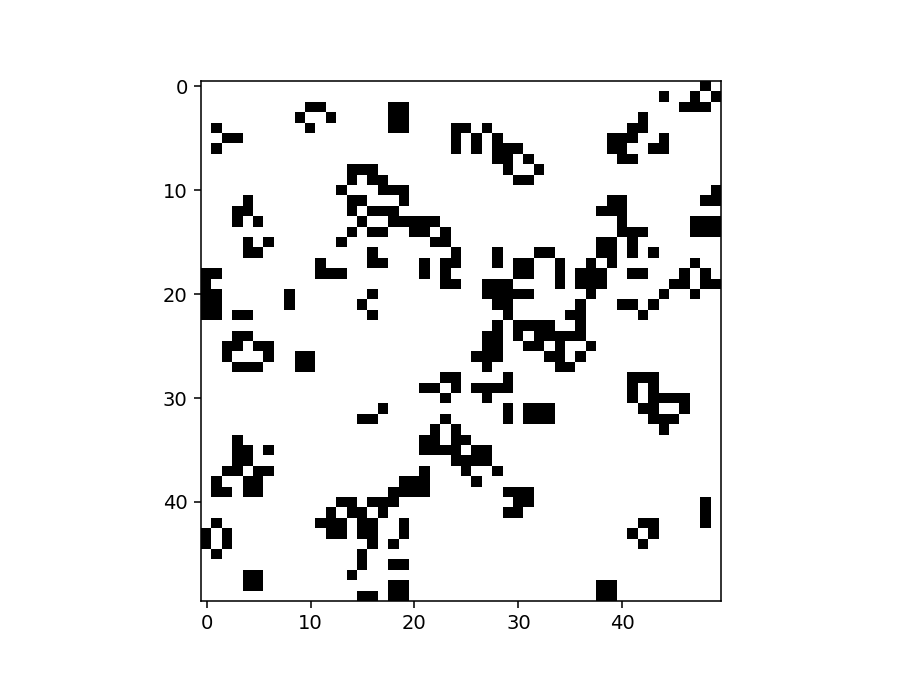

In [6]:
# Set up the initial state of the grid
initial_state = np.random.choice([0, 1], size=grid_size, p=[0.8, 0.2])

# Set up the initial plot
fig, ax = plt.subplots()
im = ax.imshow(initial_state, cmap = 'binary')

# Function to update the plot for each iteration
def animate(frame):
    im.set_array(animate.grid)
    animate.grid = update(animate.grid)

# Set the initial state of the grid for the animation
animate.grid = initial_state

# Create the animation
ani = FuncAnimation(fig, animate, frames=100, interval=200, blit=False)

# Show the animation
plt.show()

## Epidemic Simulator

We will address a few different ways to initialize our epidemic simulator, but starting out with a control group is a good templace for the initialization functions to come. Here we define `starting_state(n)` as taking an integer representing the side length of the game board. It returns the `numpy` array. 

In [42]:
def starting_state(n):
    cb = int(n/2) - 1    # We want to select a small sqaure of cells, so we find the center 
    ce = int(n/2) + 1    # And set cb and ce to be offset from the center by 1
    cells = np.zeros((n, n), dtype = int)   # Initializes the board with 0 representing a healthy cell
    cells[cb:ce, cb:ce] = 1       # Sets the small sqaure of cells to be 1, which represents a sick cell

    return cells

Let's note what our current numbering system looks like in the `matplotlib` color map that we will be using.
- ***Healthy***: Blue
- ***Sick***: Pink
- ***Recovered***: Yellow

<IPython.core.display.Javascript object>


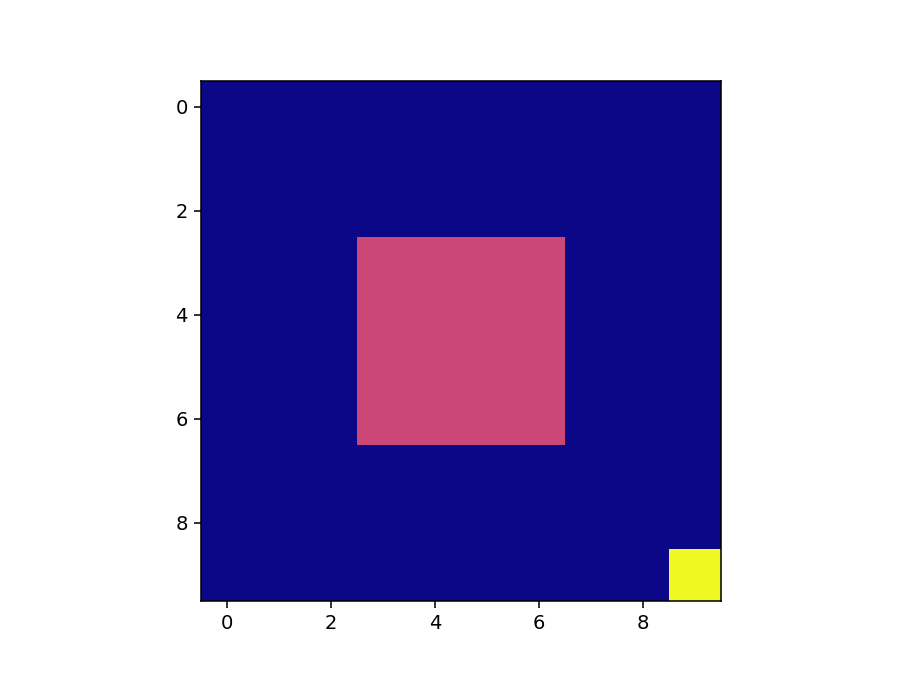

[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 1 1 1 0 0 0]
 [0 0 0 1 1 1 1 0 0 0]
 [0 0 0 1 1 1 1 0 0 0]
 [0 0 0 1 1 1 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 2]]


In [45]:
plt.figure()
x = starting_state(10)
x[9, 9] = 2
print(x)
plt.imshow(x, cmap = "plasma")

We will want our simulator to update each individual cell based on the cell's around it, just like how you and I get sick from those around us. Let's break this goal down into two different functions: `count_neighbors(cells, i, j)` and `update_spread(cells, P_I, P_R)`.

First, `count_neighbors(cells, i, j)` takes a 2D array of cells, and the i-th row and j-th column of the cell we are focused on. Since our simulator will update primarily based on the number of sick cells, we will return the number of sick neighbors to the cell [ i, j ].

In [50]:
def count_neighbors(cells, i, j):
    n = cells.shape[0]        # Stores the side length of the game board

    # This list comprehension gathers the 3 row values needed to identify the neighbors of cell [i, j]
        # Since range() is exlusive, we loop through the values of i - 1, i, and i + 1, but not i + 2
            # The inequality assures that no reference to an out-of-bounds index is being made (like when i = 0)
    a = [x for x in range(i - 1, i + 2) if (0 < x < n)]
    
    # This list comprension functions the same but identifies the 3 column values needed
    b = [y for y in range(j - 1, j + 2) if (0 < y < n)]
    
    # This list comprehension gets all combinations of (a, b) (also known as the Cartesian Product of sets a and b)
        # We exlude (i, j) with '!=' since we only care about the state of its neighbors
    coordinates = [(k, l) for k in a for l in b if (k, l) != (i, j)]
    
    # Now we count the number of sick neighbors by plugging in the coordinates we retrieved 
        # and checking if their value is 1
    sick_neighbors = 0
    for s in coordinates:
        if cells[s] == 1:
            sick_neighbors += 1
    
               
    return sick_neighbors

Next, `update_spread` will apply the probabilities that a cell gets infected or recovers, depending on its state. It takes a 2D array of cells, a float < 1 representing the rate of infection, and a float < 1 representing the rate of recovery.

In [54]:
def update_spread(cells, P_I, P_R):
    # Make a copy of the array so that each cell is updated based on the same game board, not an actively changing one
    new_cells = cells.copy()
    # Stores the length and width of the game board
    nrows, ncols = cells.shape
    
    # Nested loop goes through every cell on the game board
    for i in range(nrows):
        for j in range(ncols):
            # Storing the cell reference in variable c
            c = cells[i, j]
            # Storing the number of sick neighbors to c
            sick = count_neighbors(cells, i, j)
            
            # If c is sick
            if c == 1:
                # np.random.rand() generates between 0 and 1
                    # if it generates a number less than the rate of recovery
                if np.random.rand() <= P_R:
                    # the cell recovers and its new state is stored on the new game board
                    new_cells[i, j] = 2
            
            # If c is healthy
            if c == 0:
                # Here, we are using the formula 1 - (1 - P_I)^k, where k is the number of sick neighbors to c
                    # Essentially, as k increases, 1 - (1 - P_I)^k will increase to 1 faster, even if P_I is small
                        # i.e., the more sick neighbors => the higher change c gets sick
                if np.random.rand() <= (1 - math.pow((1 - P_I), sick)):
                    # the cell gets sick and its new state is stored on the new game board
                    new_cells[i, j] = 1
                    
    return new_cells

***
## Game 1
### Start with a 4x4 grid of sick cells

What is the size of the game? 100
What is the rate of infection? (Answer should range from 0-1) .5
What is the rate of recovery? (Answer should range from 0-1) .5


<IPython.core.display.Javascript object>


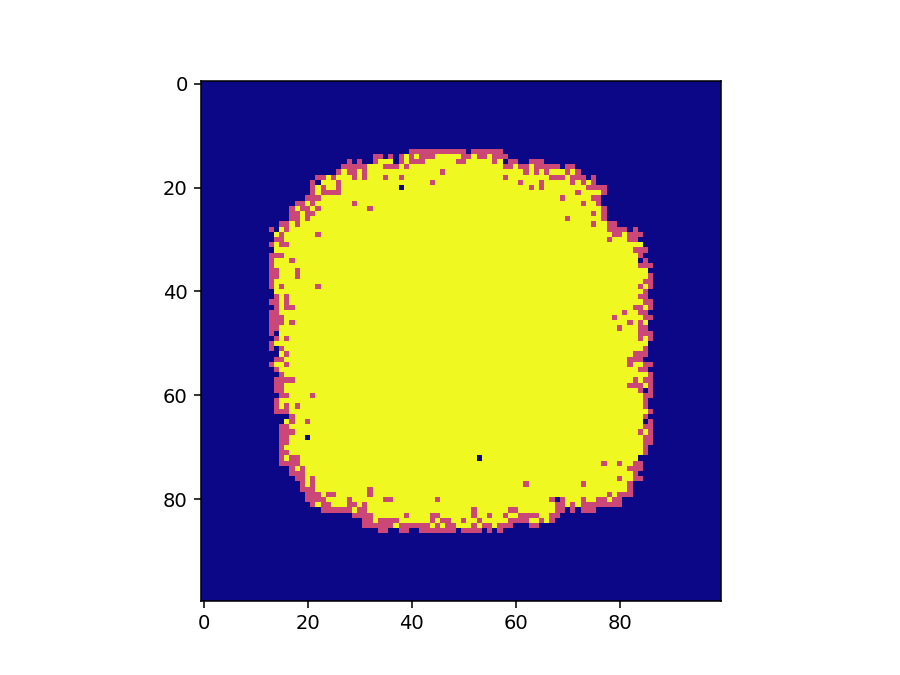

In [56]:
# Set up the initial state of the board and the initial state of the infection and recovery rates
n = int(input('What is the size of the game? '))
P_I = float(input('What is the rate of infection? (Answer should range from 0-1) '))
P_R = float(input('What is the rate of recovery? (Answer should range from 0-1) '))
board_size = starting_state(n)

# Set up the animation
fig = plt.figure()
im = plt.imshow(board_size, cmap = "plasma")

# The animation function
def animate(i):
    global board_size
    board_size = update_spread(board_size, P_I, P_R)
    im = plt.imshow(board_size, cmap = "plasma")
    return im

ani = FuncAnimation(fig, animate, frames = 100, blit = False)

plt.show()

Inputting different rates of infection and rates of recovery generally reveal that with this initial state of a cluster of sick cells the results are a direct competition between the rates. If P_I > P_R, all or almost all cells will get sick. If P_I = P_R, the mass of sick and recovered cells grows at the same rate. If P_I < P_R, the sick cells will likely be halted in their tracks and not be able to infect a portion of the cells. The interesting part with these rates are that even if P_R is larger than P_I, the sick cells are supported and boosted by each other. For example, if a healthy cell is surrounded by 4 sick cells and the rate of infection is 6%, there is actually a 21% chance that the healthy cell gets sick.

***
## Game 2
### Start with a random spread of sick cells

We want to observe how this epidemic evolves not just through different infection and recovery rates, but starting states as well. For example, what if instead of starting with a cluster of sick cells, we started with a certain percentage of sick cells based on some input float from 0 to 1.

In [57]:
def random_starting_state(n, percent_sick):
    cells = np.zeros((n, n), dtype = int)
    sick_mask = np.random.rand(n, n) < percent_sick
    cells[sick_mask] = 1

    return cells

What is the size of the game?100
What is the rate of infection? (Answer should range from 0-1).3
What is the rate of recovery? (Answer should range from 0-1).5
What percent of the population should start out as sick? (Answer should range from 0-1, but the best results come from 0-0.1).02


<IPython.core.display.Javascript object>


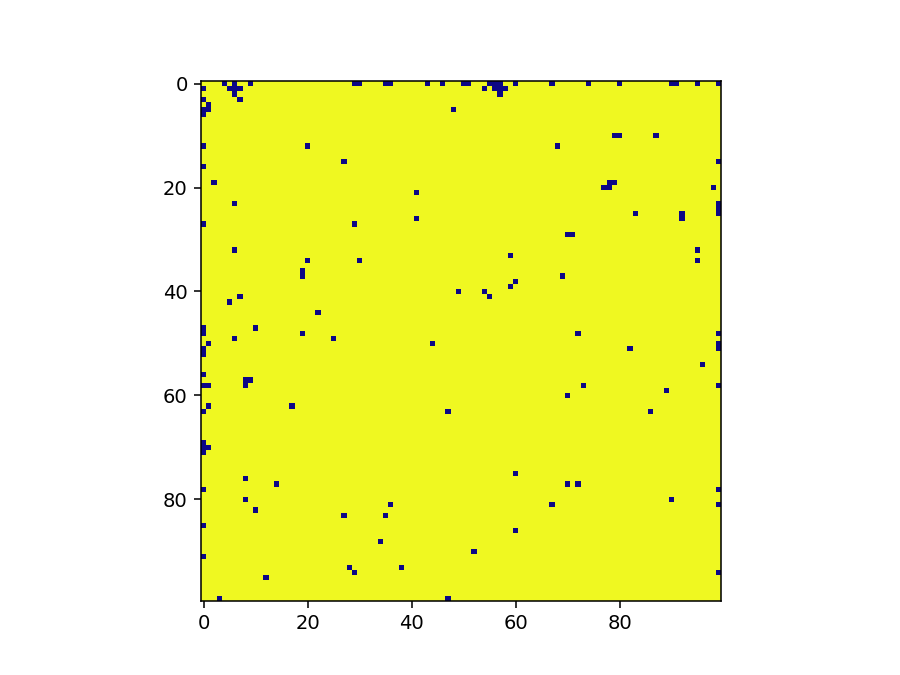

In [60]:
n = int(input('What is the size of the game?'))
P_I = float(input('What is the rate of infection? (Answer should range from 0-1)'))
P_R = float(input('What is the rate of recovery? (Answer should range from 0-1)'))
initial_sick = float(input(
'What percent of the population should start out as sick? (Answer should range from 0-1, but the best results come from 0-0.1)'))

board_size = random_starting_state(n, initial_sick)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
im = plt.imshow(board_size, cmap = "plasma")

ani = FuncAnimation(fig, animate, frames=100, blit=True)

plt.show()

Note that this randomized starting state is an advantage to the sick cells even if P_I < P_R. This is because of the formula we use to see if a healthy cell gets sick. 

***
## Game 3
### Start with a random spread of sick and vaccinated cells

In [16]:
def random_vaxxed_starting_state(n, percent_sick, percent_vaxxed):
    cells = np.zeros((n, n), dtype = int)
    sick_mask = np.random.rand(n, n) < percent_sick
    # Both the sick and vaccinated cells will be randomly dispersed
    vax_mask = np.random.rand(n, n) < percent_vaxxed
    cells[sick_mask] = 1
    # We will identify vaccinated cells as -1
    cells[vax_mask] = -1
    
    return cells

With our new state of vaccinated, let's note what our current numbering system looks like in the `matplotlib` color map that we will be using.
- ***Vaccinated***: Blue
- ***Healthy***: Purple
- ***Sick***: Orange/Salmon
- ***Recovered***: Yellow

<IPython.core.display.Javascript object>


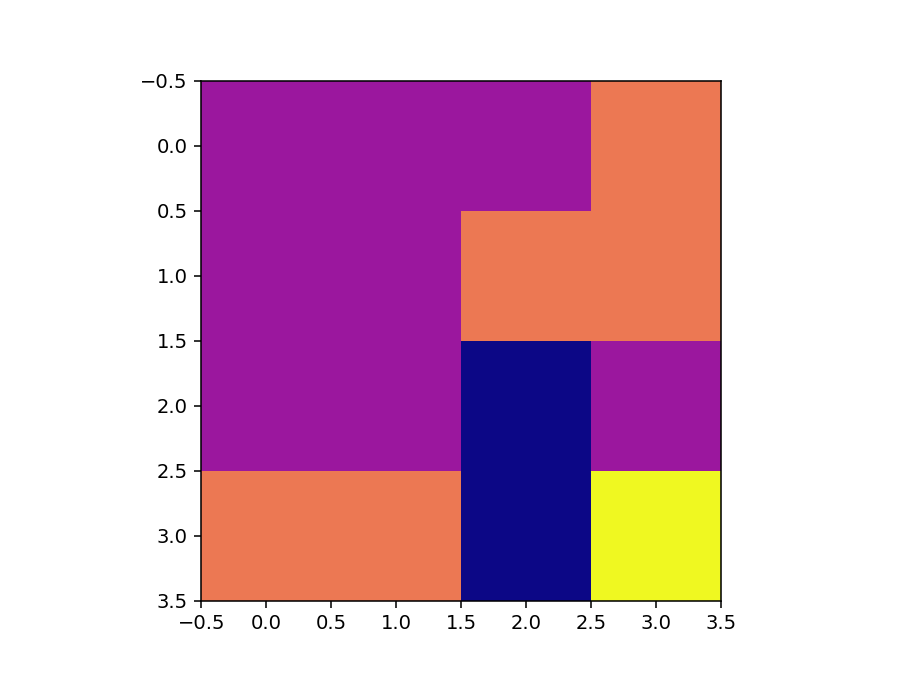

[[ 0  0  0  1]
 [ 0  0  1  1]
 [ 0  0 -1  0]
 [ 1  1 -1  2]]


In [63]:
plt.figure()
x = random_vaxxed_starting_state(4, .3, .3)
x[3, 3] = 2
print(x)
plt.imshow(x, cmap = "plasma")

What is the size of the game? (100 or less is recommended)100
What is the rate of infection? (Answer should range from 0-1).5
What is the rate of recovery? (Answer should range from 0-1).5
What percent of the population should start out as sick? (Answer should range from 0-1, but the best results come from 0-0.1).02
What percent of the population is vaccinated? (Answer should range from 0-1).5


<IPython.core.display.Javascript object>


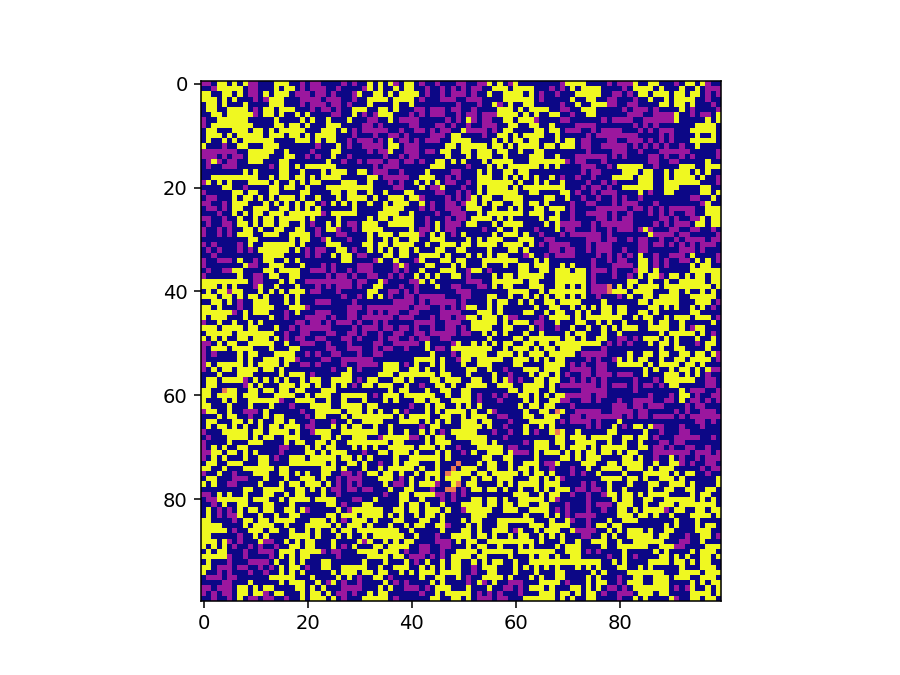

In [69]:
n = int(input('What is the size of the game? (100 or less is recommended)'))
P_I = float(input('What is the rate of infection? (Answer should range from 0-1)'))
P_R = float(input('What is the rate of recovery? (Answer should range from 0-1)'))
initial_sick = float(input(
'What percent of the population should start out as sick? (Answer should range from 0-1, but the best results come from 0-0.1)'))
initial_vaxxed = float(input('What percent of the population is vaccinated? (Answer should range from 0-1)'))

board_size = random_vaxxed_starting_state(n, initial_sick, initial_vaxxed)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
im = plt.imshow(board_size, cmap = "plasma")

ani = FuncAnimation(fig, animate, frames=100, blit=True)

plt.show()

Change around the values of the vaccinated cells and see how a vaccination does best when the percent of cells vaccinated is approximately the rate of infection (or more is ideal). If not enough cells are vaccinated and the infection rate i